## Dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
np.random.seed(0)

# Data Preprocessing

## Read data

In [2]:
def read_data(sbj_i, srs_i):
    x = pd.read_csv('./data/train/subj{}_series{}_data.csv'  .format(sbj_i, srs_i), index_col='id')
    y = pd.read_csv('./data/train/subj{}_series{}_events.csv'.format(sbj_i, srs_i), index_col='id')
    return x,y

Separate data between training and validation

In [3]:
data = [read_data(i,j) for j in range(1,9) for i in range(1,13)]

In [4]:
print('There are {} series in total.'.format(len(data)))

There are 96 series in total.


## Standardization

In [5]:
scaler = StandardScaler()

all_x = pd.DataFrame()
for x,_ in data:
    all_x = pd.concat((x, all_x))

scaler.fit(all_x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
train = []
for x,y in data:
    train.append([scaler.transform(x),y])

In [7]:
# # visualization
# xcols = data[0][0].columns
# fig = plt.figure(figsize=(25,200))

# for idx,col in enumerate(xcols):
#     xx = []
#     ax = fig.add_subplot(len(xcols), 1, idx+1)
#     for x,y in train:
#         xx.append(x[col])
# #         break
#     ax.boxplot(xx, showfliers=False)
#     break

## Separate into Train/Valid

We randomly select one series from each subject to be part of the validation set.

In [8]:
valid_idxs = reversed([0,14,23,25,37,44,50,57,65,78,80,94])
valid = [train.pop(i) for i in valid_idxs]

In [9]:
len(train), len(valid)

(84, 12)

In [10]:
x,y = train[0]
display(x[:10])
display(y.head())
print("First series has length: {}".format(len(y)))

array([[ 9.35307596e-01, -5.33433450e-02, -1.72135124e+00,
        -8.06662124e-01,  6.61872667e-02,  5.43867439e-01,
         1.28064908e-01, -4.82233472e-01,  1.32653733e+00,
         1.32760938e+00,  3.90857195e-01, -8.93065845e-01,
         4.73817947e+00,  2.15677800e+00,  1.19188958e+00,
         1.11753778e+00, -4.46995718e-01, -7.40997630e-01,
         1.83291025e+00,  8.36433256e-01,  1.04905821e+00,
         1.34776829e+00,  4.92176623e-01,  2.77917604e+00,
         1.70834393e+00,  4.84734705e-01,  5.24557603e-01,
         2.72925171e-01,  9.96606362e-01,  1.87745860e+00,
         2.67788480e-01,  5.88204462e-01],
       [ 9.33397552e-01, -1.90728276e-02, -1.66025906e+00,
        -6.68513544e-01,  6.05327763e-02,  7.01014904e-01,
         1.23956463e-01, -3.94461976e-01,  1.56226182e+00,
         1.45132501e+00,  4.84879213e-01, -9.38378471e-01,
         4.85866213e+00,  2.27391795e+00,  1.28434010e+00,
         1.14263616e+00, -3.46854443e-01, -6.52104522e-01,
         1.93

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
id,,,,,,
subj2_series1_0,0,0,0,0,0,0
subj2_series1_1,0,0,0,0,0,0
subj2_series1_2,0,0,0,0,0,0
subj2_series1_3,0,0,0,0,0,0
subj2_series1_4,0,0,0,0,0,0


First series has length: 291874


## Further Data Exploration

In this section we are going to explore the data, checking for possible label imbalances for instance.

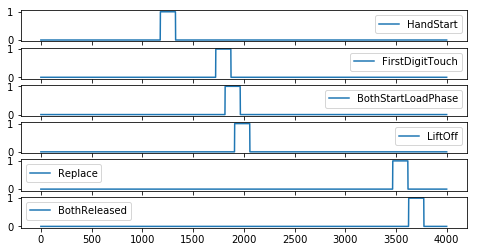

In [11]:
fig = plt.figure(figsize=(8,4))
cols = train[0][1].columns
first_ax = None

for idx,col in enumerate(cols):
    if first_ax == None:
        ax = fig.add_subplot(len(cols),1,idx+1)
        first_ax = ax
    else: 
        ax = fig.add_subplot(len(cols),1,idx+1, sharex=first_ax)
    ax.plot(train[6][1].reset_index()[col][:4000], label=col)
    ax.legend()

In the figure above we have plotted how each label evolve over time for one repetition of the grasp-and-lift movement. We can see that there is some overlapping of labels, specially for the "FirstDigitTouch", "BothStartLoadPhase" and "LiftOff" labels. Therefore, we must NOT apply a softmax function at our outputs, but a sigmoid instead.

# Define Model Class (Pipeline)

In [12]:
class Model(object):
    
    def __init__(self, model_def, window_size=None):
        # define tensorflow graph
        if window_size != None:
            self.inputs = tf.placeholder(tf.float32, [None, window_size, 32])
            self.logits = model_def(self.inputs, window_size)
        else:
            self.inputs = tf.placeholder(tf.float32, [None, 32])
            self.logits = model_def(self.inputs)
        self.window_size = window_size
        
        self.labels = tf.placeholder(tf.float32, [None,  6])
        self.preds = tf.nn.sigmoid(self.logits)      
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.labels))
        
    
    def set_data(self, train, valid):
        self.train = train
        self.valid = valid
        
    def fit(self, epochs, batch_size, batches_gen, lr=0.001):
        self.optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.cost)
        self.sess = tf.Session()
        start_time = time.time()
        self.sess.run(tf.global_variables_initializer())
        # loop through epochs
        for e in range(epochs):
            loss = 0
            n_total_batches = 0
            # loop through training series (and subjects)
            for xx,yy in batches_gen(self.train, batch_size, self.window_size, shuffle=True):
                self.sess.run(self.optimizer, feed_dict={self.inputs: xx, self.labels: yy}) # train (update weights)
                loss += self.sess.run(self.cost, feed_dict={self.inputs: xx, self.labels: yy}) # calculate loss
                n_total_batches += 1
            
            # print train and valid information
            loss /= n_total_batches # get mean loss to make loss comparable among different batch sizes
            valid_mean_auc = self.validate(batch_size, batches_gen)
            print("Epoch: {},\tMean Loss: {},\tValid Mean AUC: {}".format(e, loss, valid_mean_auc))

        train_time = time.time() - start_time
        print("Model was trained in {} seconds.".format(train_time))
        
        
    def validate(self, batch_size, batches_gen):
        """Calculate the ROC AUC for a list of (features, labels) tuples."""
        total_predictions = []
        total_labels = pd.DataFrame()
        for xx,yy in batches_gen(self.valid, batch_size, self.window_size, shuffle=False):
            predictions = self.sess.run(self.preds, feed_dict={self.inputs: xx})
            total_predictions.extend(predictions)
            total_labels = pd.concat((total_labels, yy))
        mean_auc = roc_auc_score(total_labels, total_predictions, average='macro')
        return mean_auc

# Models

In [13]:
def feedforward_nn(inputs):
    l1 = tf.layers.dense(inputs, 16)
    l2 = tf.layers.dense(l1    , 10)
    l3 = tf.layers.dense(l2    ,  6)
    return l3
            
def feedforward_batches_gen(xy_series, batch_size, window_size=None, shuffle=False):
    """Generate batches of length `batch_size` from a list of (features, labels) tuples."""
    xy_indexes = np.arange(len(xy_series))
    if shuffle: np.random.shuffle(xy_indexes)
    for i in xy_indexes:
        x,y = xy_series[i]
        n_batches = (len(x) + batch_size - 1) // batch_size
        for b in range(n_batches): # ceil division to do not discard datapoints
            # slice features and labels to the current batch interval
            xx = x[batch_size*b : batch_size*(b+1)]
            yy = y[batch_size*b : batch_size*(b+1)]
            yield xx, yy

In [25]:
def conv_nn(inputs, window_size): # Bx1024x32
    lconv = tf.layers.conv1d(inputs, filters=64, kernel_size=3, strides=1, activation=tf.nn.relu, padding='same') # Bx1024x64
    lpool = tf.layers.max_pooling1d(lconv, pool_size=2, strides=2, padding='same') # Bx512x64
    lflat = tf.reshape(lpool, [-1, (window_size/2)*64]) # Bx(512*64)
    ldense = tf.layers.dense(lflat, 128, activation=tf.nn.relu) # Bx128
    logits = tf.layers.dense(ldense, 6) # Bx6
    return logits

def conv_batches_gen(xy_series, batch_size, window_size, shuffle=False):
    """Generate batches of length `batch_size` from a list of (features, labels) tuples."""
    xy_indexes = np.arange(len(xy_series))
    if shuffle: np.random.shuffle(xy_indexes)
    for i in xy_indexes:
        x,y = xy_series[i]
        # we cannot fit any data point before (window_size - 1)
        end_indexes = np.arange(window_size, len(x))
        if shuffle: np.random.shuffle(end_indexes)
        n_batches = (len(end_indexes) + batch_size - 1) // batch_size # trick to ceil using floor division
        for b in range(n_batches):
            end_idxs = end_indexes[batch_size*b : batch_size*(b+1)] # get a list for the current final indices of xy_series for this batch
            start_idxs = end_idxs - window_size
            slices = []
            for s,e in zip(start_idxs, end_idxs):
                slices.append(np.arange(s,e))
            slices = np.array(slices) # needed to make index selection correct below
            yield x[slices], y.iloc[end_idxs]

# Train and Validate model

In [26]:
nn = Model(conv_nn, window_size=1024)

In [27]:
nn.set_data([train[0]], [valid[0]])

In [29]:
nn.fit(
    epochs=1,
    batch_size=128,
    batches_gen=conv_batches_gen,
)

1
2
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5


4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5


# Debug

In [22]:
g = conv_batches_gen(train, batch_size=128, window_size=1024, shuffle=True)

In [23]:
x,y = next(g)

In [24]:
x.shape

(128, 1024, 32)

In [ ]:
y

In [ ]:
def ttt(a):
    return a

In [ ]:
x,y = train[0]

In [ ]:
np.array(y)[np.array([5,6,9])]

In [ ]:
sl = np.array([1,2,3,4,5])
x[np.array([[1,2,3],[2,3,4]])]

In [ ]:
# debugging
xx = train[0][0][0:100]
yy = train[0][1][0:100]
predictions = sess.run(logits, feed_dict={inputs: xx, labels: yy})
print predictions

In [ ]:
train[0][1][0:100]

In [ ]:
sum_ = 0
for x,y in valid:
    sum_ += len(x)
sum_

In [ ]:
roc_auc_score([1,1,0], [0.95, 0.86, 0.02], average='macro')

In [ ]:
a = [0:10]